In [1]:
from pyspark.sql.types import *

In [2]:
event = StructType([
    StructField('event_id', StringType(), True),
    StructField('event_name', StringType(), True),
    StructField('event_url', StringType(), True),
    StructField('time', LongType(), True)
])
group_topics = ArrayType(StructType([
    StructField('urlkey', StringType(), True),
    StructField('topic_name', StringType(), True)
]))
group = StructType([
    StructField('group_city', StringType(), True),
    StructField('group_country', StringType(), True),
    StructField('group_id', IntegerType(), True),
    StructField('group_name', StringType(), True),
    StructField('group_lon', FloatType(), True),
    StructField('group_lat', FloatType(), True),
    StructField('group_urlname', StringType(), True),
    StructField('group_state', StringType(), True),
    StructField('group_topics', group_topics, True)
])
venue = StructType([
    StructField('venue_name', StringType(), True),
    StructField('lon', FloatType(), True),
    StructField('lat', FloatType(), True),
    StructField('venue_id', IntegerType(), True),
])
member = StructType([
    StructField('member_id', IntegerType(), True),
    StructField('photo', StringType(), True),
    StructField('member_name', StringType(), True),
])
schema = StructType([
    StructField('event', event, True),
    StructField('group', group, True),
    StructField('venue', venue, True),
    StructField('visibility', StringType(), True),
    StructField('response', StringType(), True),
    StructField('guests', IntegerType(), True),
    StructField('member', member, True),
    StructField('rsvp_id', LongType(), True),
    StructField('mtime', LongType(), True)
])

In [3]:
df = spark.read.json('file:///home/bondk/Data/2018-03-29_061608.json', schema)

In [4]:
df.printSchema()

root
 |-- event: struct (nullable = true)
 |    |-- event_id: string (nullable = true)
 |    |-- event_name: string (nullable = true)
 |    |-- event_url: string (nullable = true)
 |    |-- time: long (nullable = true)
 |-- group: struct (nullable = true)
 |    |-- group_city: string (nullable = true)
 |    |-- group_country: string (nullable = true)
 |    |-- group_id: integer (nullable = true)
 |    |-- group_name: string (nullable = true)
 |    |-- group_lon: float (nullable = true)
 |    |-- group_lat: float (nullable = true)
 |    |-- group_urlname: string (nullable = true)
 |    |-- group_state: string (nullable = true)
 |    |-- group_topics: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- urlkey: string (nullable = true)
 |    |    |    |-- topic_name: string (nullable = true)
 |-- venue: struct (nullable = true)
 |    |-- venue_name: string (nullable = true)
 |    |-- lon: float (nullable = true)
 |    |-- lat: float (nullable =

In [5]:
def download_file(dir, url):
    import urllib.request
    import os.path
    if os.path.exists(dir):
        print(dir, 'file already exist')
    else:
        urllib.request.urlretrieve(url, dir)
        print('File saved to', dir)

url = 'https://pkgstore.datahub.io/core/country-list/data_csv/data/d7c9d7cfb42cb69f4422dec222dbbaa8/data_csv.csv'
dir = '/home/bondk/Data/country_code.csv'
download_file(dir, url)

/home/bondk/Data/country_code.csv file already exist


In [6]:
from pyspark.sql.functions import *
country_code = spark.read \
    .option('header', 'true') \
    .option('inferSchema', value=True) \
    .csv('file://' + dir) \
    
country_code_lower = country_code.withColumn('Code_Lower', lower(country_code['Code']))
country_code_lower.show()

+-------------------+----+----------+
|               Name|Code|Code_Lower|
+-------------------+----+----------+
|        Afghanistan|  AF|        af|
|      Åland Islands|  AX|        ax|
|            Albania|  AL|        al|
|            Algeria|  DZ|        dz|
|     American Samoa|  AS|        as|
|            Andorra|  AD|        ad|
|             Angola|  AO|        ao|
|           Anguilla|  AI|        ai|
|         Antarctica|  AQ|        aq|
|Antigua and Barbuda|  AG|        ag|
|          Argentina|  AR|        ar|
|            Armenia|  AM|        am|
|              Aruba|  AW|        aw|
|          Australia|  AU|        au|
|            Austria|  AT|        at|
|         Azerbaijan|  AZ|        az|
|            Bahamas|  BS|        bs|
|            Bahrain|  BH|        bh|
|         Bangladesh|  BD|        bd|
|           Barbados|  BB|        bb|
+-------------------+----+----------+
only showing top 20 rows



In [7]:
count = df.groupBy('group.group_country').count().orderBy('count', ascending=False)
count_country_name = count.join(country_code_lower, count.group_country == country_code_lower.Code_Lower, 'left') \
    .select('Name', 'count', 'Code_Lower').limit(20)
count_country_name.show()

+------------------+-----+----------+
|              Name|count|Code_Lower|
+------------------+-----+----------+
|     United States|48529|        us|
|    United Kingdom|10879|        gb|
|            Canada| 4838|        ca|
|             Spain| 3585|        es|
|           Germany| 3560|        de|
|            France| 3478|        fr|
|         Australia| 2688|        au|
|             India| 2604|        in|
|       Netherlands| 1832|        nl|
|            Brazil| 1296|        br|
|         Singapore| 1282|        sg|
|             Japan| 1261|        jp|
|            Poland| 1121|        pl|
|           Ireland|  861|        ie|
|Korea, Republic of|  762|        kr|
|       Switzerland|  704|        ch|
|         Hong Kong|  682|        hk|
|            Israel|  600|        il|
|            Sweden|  591|        se|
|            Turkey|  581|        tr|
+------------------+-----+----------+



In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

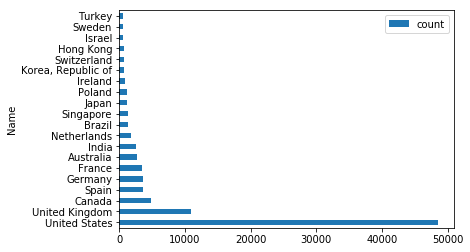

In [9]:
count_country_name.toPandas().set_index('Name').plot(kind='barh')

In [10]:
count_state_name = df.filter(df['group.group_country'] == 'us').groupBy('group.group_state').count().orderBy('count', ascending=False).limit(20)
count_state_name.show()

+-----------+-----+
|group_state|count|
+-----------+-----+
|         CA| 8696|
|         NY| 5618|
|         TX| 3377|
|         FL| 3166|
|         IL| 1913|
|         MA| 1897|
|         NC| 1852|
|         PA| 1816|
|         CO| 1811|
|         VA| 1755|
|         GA| 1367|
|         DC| 1337|
|         WA| 1333|
|         OH| 1202|
|         NJ| 1195|
|         AZ| 1125|
|         OR| 1044|
|         MD|  948|
|         MI|  904|
|         MN|  662|
+-----------+-----+



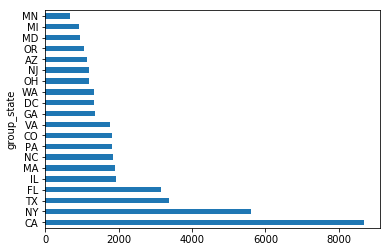

In [11]:
count_state_name.toPandas().set_index('group_state').plot(kind='barh', legend=None)

In [12]:
count_CA_city_name = df.filter(df['group.group_country'] == 'us').filter(df['group.group_state'] == 'CA').groupBy('group.group_city').count().orderBy('count', ascending=False).limit(20)
count_CA_city_name.show()

+-------------+-----+
|   group_city|count|
+-------------+-----+
|San Francisco| 1315|
|  Los Angeles| 1013|
|    San Diego|  791|
|     San Jose|  329|
|   Sacramento|  305|
|       Irvine|  252|
|      Oakland|  198|
|    Palo Alto|  179|
|Mountain View|  163|
| Santa Monica|  144|
|  Santa Clara|  139|
|    Sunnyvale|  132|
|     Berkeley|  119|
|Santa Barbara|   88|
|   Santa Rosa|   85|
|   Long Beach|   79|
|Mission Viejo|   77|
|   Santa Cruz|   71|
|     Pasadena|   71|
|   Carmichael|   66|
+-------------+-----+



In [13]:
def get_tags(topics):
    return topics.asDict()['urlkey'] if topics.asDict() else []

hot_topics = df.select('group.group_topics.urlkey') \
    .rdd.flatMap(lambda row: get_tags(row)) \
    .map(lambda topic: (topic, 1)) \
    .reduceByKey(lambda x, y: x + y) \
    .sortBy(lambda x: x[1], ascending=False) \
    .toDF(['Topic', 'Count']) \
    .persist()

In [14]:
print(hot_topics.count())

19705


In [15]:
hot_topics.show(truncate=False)

+-----------------------+-----+
|Topic                  |Count|
+-----------------------+-----+
|social                 |15523|
|socialnetwork          |14513|
|newintown              |14032|
|outdoors               |12349|
|softwaredev            |12176|
|fun-times              |11939|
|computer-programming   |9566 |
|entrepreneurship       |9506 |
|web-development        |9456 |
|newtech                |9451 |
|hiking                 |9317 |
|self-improvement       |8678 |
|opensource             |8627 |
|adventure              |8467 |
|professional-networking|8441 |
|diningout              |8344 |
|fitness                |7689 |
|excercise              |7448 |
|singles                |7148 |
|web                    |7135 |
+-----------------------+-----+
only showing top 20 rows



In [16]:
df.select('event.event_id', 'event.event_name', 'group.group_country', 'group.group_city') \
    .groupBy('event_id', 'event_name', 'group_country', 'group_city') \
    .count() \
    .select('event_name', 'group_country', 'group_city', 'count') \
    .orderBy('count', ascending=False) \
    .show(40, truncate=False)

+-------------------------------------------------------------------------------+-------------+-------------+-----+
|event_name                                                                     |group_country|group_city   |count|
+-------------------------------------------------------------------------------+-------------+-------------+-----+
|17th Deep Learning Meetup in Vienna                                            |at           |Vienna       |190  |
|L'UX dans les Jeux vidéo                                                       |fr           |Paris        |134  |
|Scaling Bayesian inference by constructing approximating exponential families  |us           |Boston       |124  |
|vodQA 18th Edition: Security Testing 101 - Hack. Secure. Repeat.               |in           |Chennai      |92   |
|SciPy-SP #7 + Data Science                                                     |br           |São Paulo    |92   |
|The Spring Edition 🌱 WebAssembly, JS Blockchain, NativeScript          

In [17]:
state_count = df.select('group.group_country', 'group.group_state', 'event.event_id') \
    .filter(df['group.group_country'] == 'us') \
    .groupBy('group_state', 'event_id') \
    .count()
state_count.show()

+-----------+------------+-----+
|group_state|    event_id|count|
+-----------+------------+-----+
|         FL|mjzgwmyxgbgb|    2|
|         TX|cbdjlpyxfbpc|    2|
|         TX|   248083232|    5|
|         CA|bjtcxlyxgbcc|    3|
|         CA|srwxlpyxgbnb|    1|
|         OR|scmmmpyxgbfb|    1|
|         MI|   248205167|    6|
|         GA|rmbhlpyxgbfb|    3|
|         CA|   249220439|    1|
|         FL|   245892749|    2|
|         SC|   246245073|    1|
|         NV|   249111620|    2|
|         MD|cmnjmlyxfbmc|    1|
|         DC|   249135584|    2|
|         OH|lwzxxnyxgbwb|    2|
|         PA|jcrvmpyxgbxb|    1|
|         PA|jsnvmpyxjbvb|    1|
|         OH|   248749795|    1|
|         DC|   248197470|    1|
|         FL|   249191026|    1|
+-----------+------------+-----+
only showing top 20 rows



In [18]:
state_max = state_count.groupBy('group_state').agg(max('count').alias('max')).withColumnRenamed('group_state', 'state')
state_max.show()

+-----+---+
|state|max|
+-----+---+
|   SC|  6|
|   AZ| 19|
|   LA| 10|
|   MN| 23|
|   NJ| 24|
|   DC| 53|
|   OR| 18|
|   VA| 52|
|   RI| 27|
|   KY|  8|
|   WY|  2|
|   NH|  7|
|   MI| 16|
|   NV| 15|
|   WI| 18|
|   ID|  8|
|   CA| 43|
|   CT| 16|
|   NE|  6|
|   MT|  4|
+-----+---+
only showing top 20 rows



In [19]:
state_max_event_id = state_max.join(state_count,
                                    (state_max['max'] == state_count['count']) 
                                    & (state_max.state == state_count.group_state), 'inner')
state_max_event_id.show()

+-----+---+-----------+------------+-----+
|state|max|group_state|    event_id|count|
+-----+---+-----------+------------+-----+
|   MT|  4|         MT|   249231873|    4|
|   NC| 33|         NC|   249228190|   33|
|   NM| 10|         NM|   249211997|   10|
|   MN| 23|         MN|   248891870|   23|
|   MI| 16|         MI|xbpngpyxgbfb|   16|
|   NE|  6|         NE|xljlcpyxgbgb|    6|
|   NE|  6|         NE|   247836936|    6|
|   NE|  6|         NE|   247566434|    6|
|   AZ| 19|         AZ|   249227943|   19|
|   MA|124|         MA|   249223271|  124|
|   NJ| 24|         NJ|   249232173|   24|
|   OK| 14|         OK|   249223984|   14|
|   CA| 43|         CA|   249231735|   43|
|   VT|  4|         VT|   247085539|    4|
|   VT|  4|         VT|   248805600|    4|
|   GA| 17|         GA|pvzlxlyxgbxb|   17|
|   AL| 29|         AL|   249227319|   29|
|   KY|  8|         KY|   248453531|    8|
|   WY|  2|         WY|pfvjlpyxgbvb|    2|
|   VA| 52|         VA|   249225507|   52|
+-----+---+

In [20]:
popular_event_by_state = df.join(broadcast(state_max_event_id), 
                                 (state_max_event_id.group_state == df.group.group_state) 
                                 & (state_max_event_id.event_id == df.event.event_id), 'inner')

popular_event_by_state.select('state', 'max', 'event.event_name', 'event.time') \
    .orderBy('state', 'max') \
    .distinct() \
    .withColumn('time', from_unixtime(col('time')/1000, format='yyyy-MM-dd')) \
    .show(100, truncate=False)

+-----+---+-------------------------------------------------------------------------------+----------+
|state|max|event_name                                                                     |time      |
+-----+---+-------------------------------------------------------------------------------+----------+
|AK   |5  |Hack Night                                                                     |2018-04-03|
|AL   |29 |Artificial Intelligence and Python                                             |2018-05-08|
|AP   |4  |Join Thursday "Open Mic"  &  Friday "Oldies" w/food, wine and conversatioin    |2018-03-30|
|AR   |5  |Python User Group of Central Arkansas Monthly Meeting                          |2018-03-29|
|AZ   |19 |90s Theme Bar Crawl - Old Town Scottsdale - April 14, 2018                     |2018-04-14|
|CA   |43 |Why Comedy Matters                                                             |2018-04-01|
|CO   |18 | We Buy Houses: Nobody Cares - Brooks O'Hearn                 